In [6]:
import mysql.connector
import pandas as pd
import numpy as np  
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats

def r(x, y):
    return x != y


def calc_MSD(a, b):
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / max(a.size, b.size)*100

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDB"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_sessions, rowcol_sessions FROM study_info', con=mydb)

user_id_start = 91
user_df = user_df[(user_df.id >= user_id_start) & (user_df.id != 119)].drop_duplicates()

user_df

,id,nomon_sessions,rowcol_sessions
5,91,2,2
7,98,10,10
8,105,1,1
9,112,0,0
11,126,1,2
12,133,4,5
13,140,5,4
14,147,0,0
15,154,2,2
16,161,2,2


In [10]:
entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Uncorrected Error Rate (%)", "Time Rotate", 
                                 "Scan Delay", "Extra Delay"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}
for user in users:
    for software in software_names.keys():
        software_sessions = user_df[(user_df.id == user)][software+"_sessions"].values[0]
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            for phrase_num in phrase_nums:
                trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
                
                mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                first_press = click_times[0][0]
                num_clicks = sum([len(click_arr) for click_arr in click_times])
                if (software == "rowcol"):
                    num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
                else:
                    num_mispress = 0
                
                mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                last_selection = mycursor.fetchall()[0][0]

                mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                typed_text = mycursor.fetchall()[0][0]
                typed_len = len(typed_text)
                if session_num == 10:
                    typed_len /= 2
                
                mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
                phrase_text = mycursor.fetchall()[0][0]
                uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
                num_selections = mycursor.fetchall()[0][0]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " AND (selection = '@' OR typed_text = '#')")
                num_corrections = mycursor.fetchall()[0][0]
                
                if software == "nomon":
                    mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    rotate_ind = mycursor.fetchall()[0][0]
                    trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
                else:
                    mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    scan_delay, extra_delay = mycursor.fetchall()[0]
                    trial_data["Scan Delay"] = scan_delay_li[scan_delay]
                    trial_data["Extra Delay"] = extra_delay_li[extra_delay]
                
                
                trial_data["typed_len"] = typed_len
                trial_data["start"] = first_press
                trial_data["end"] = last_selection
                trial_data["num_click"] = num_clicks
                trial_data["num_sel"] = num_selections
                trial_data["num_corr"] = num_corrections + num_mispress
                trial_data["Uncorrected Error Rate (%)"] = uncorrected_error
                
                
                entry_df = entry_df.append(trial_data, ignore_index=True)

entry_df["Entry Rate (wpm)"] = entry_df.typed_len / (entry_df.end - entry_df.start) / 5 * 60
entry_df["Click Load (clicks/character)"] = entry_df.num_click / entry_df.typed_len
entry_df["Correction Rate (%)"] = entry_df.num_corr / entry_df.num_sel * 100

entry_df["id"] = pd.to_numeric(entry_df["id"])
entry_df["Session Number"] = pd.to_numeric(entry_df["Session Number"])
entry_df["Entry Rate (wpm)"] = pd.to_numeric(entry_df["Entry Rate (wpm)"])
entry_df["Click Load (clicks/character)"] = pd.to_numeric(entry_df["Click Load (clicks/character)"])
entry_df["Correction Rate (%)"] = pd.to_numeric(entry_df["Correction Rate (%)"])
entry_df["Uncorrected Error Rate (%)"] = pd.to_numeric(entry_df["Uncorrected Error Rate (%)"])
entry_df["Time Rotate"] = pd.to_numeric(entry_df["Time Rotate"])


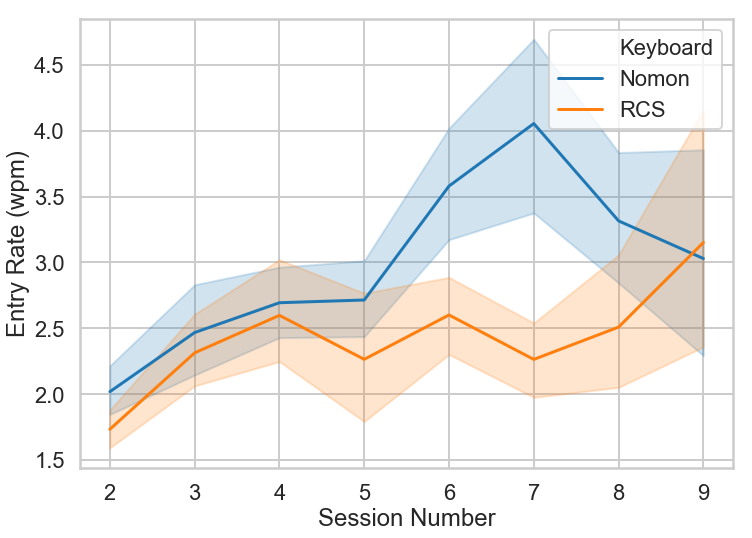

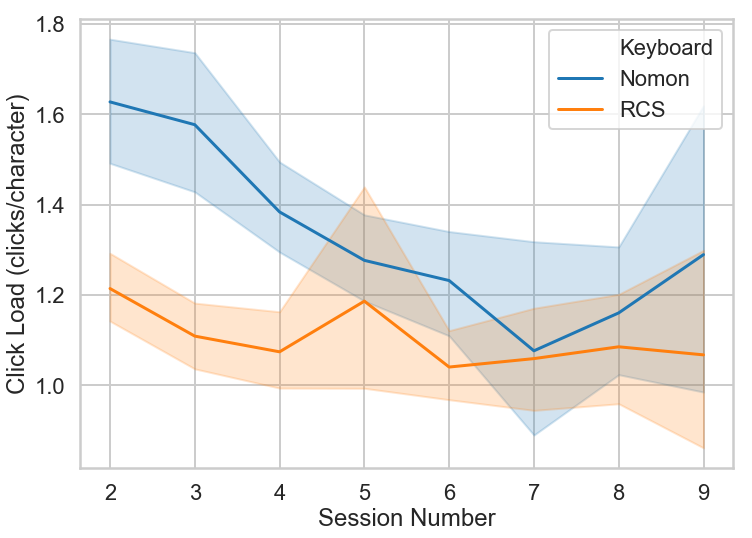

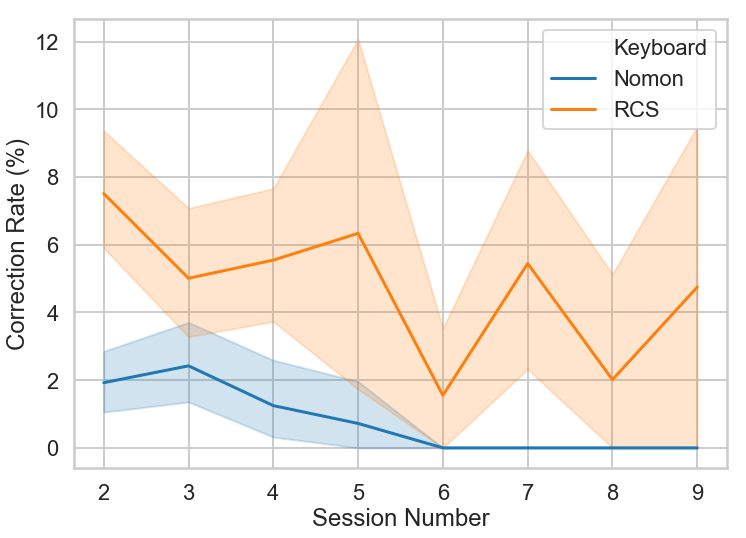

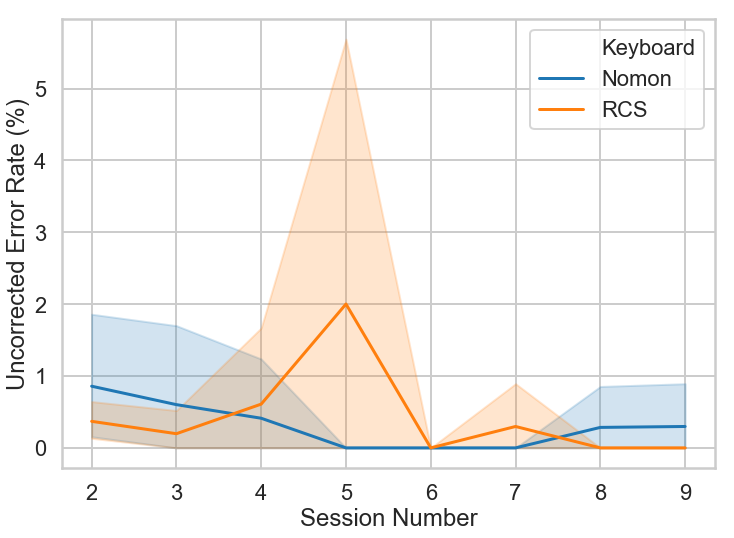

In [11]:
sns.set_context("poster")
sns.set_style("whitegrid")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Entry Rate (wpm)", hue="Keyboard",
              data=entry_df[(entry_df["Session Number"] > 1) & (entry_df["Session Number"] < 10)], ax=ax)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/entry_rate.png")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Click Load (clicks/character)", hue="Keyboard", 
             data=entry_df[(entry_df["Session Number"] > 1) & (entry_df["Session Number"] < 10)], ax=ax)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/click_load.png")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Correction Rate (%)", hue="Keyboard", 
             data=entry_df[(entry_df["Session Number"] > 1) & (entry_df["Session Number"] < 10)], ax=ax)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/correction_rate.png")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Uncorrected Error Rate (%)", hue="Keyboard", 
             data=entry_df[(entry_df["Session Number"] > 1) & (entry_df["Session Number"] < 10)], ax=ax)
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/error_rate.png")


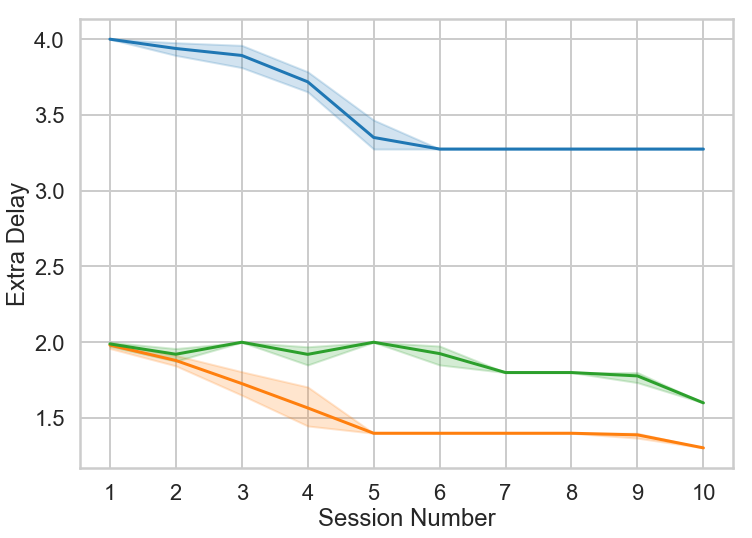

In [4]:
a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Time Rotate", 
             
             data=entry_df[entry_df["Session Number"] >= 1], ax=ax)
sns.lineplot(x="Session Number", y="Scan Delay", 
             data=entry_df[entry_df["Session Number"] >= 1], ax=ax)
sns.lineplot(x="Session Number", y="Extra Delay",
             data=entry_df[entry_df["Session Number"] >= 1], ax=ax)


Entry Rate (wpm)
Entry Rate (wpm) 0.0015909879064860196
Click Load (clicks/character)
Click Load (clicks/character) 0.3676537499686967
Correction Rate (%)
Correction Rate (%) 8.594019530713591e-05
Uncorrected Error Rate (%)
Uncorrected Error Rate (%) 0.33377286885639024


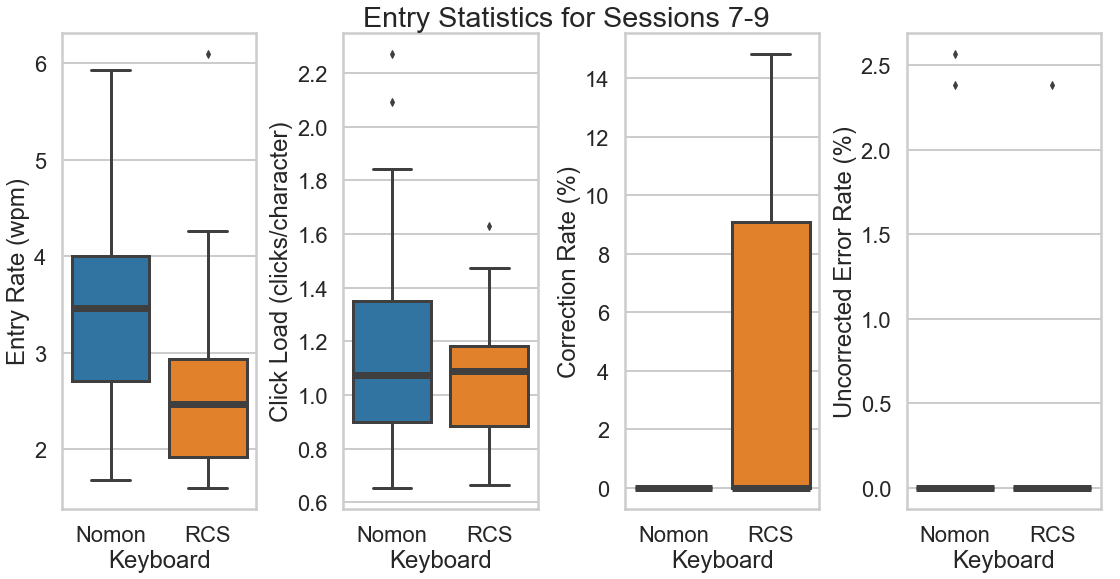

In [6]:

final_df = entry_df[(entry_df["Session Number"] >= 7) & (entry_df["Session Number"] < 10)]

entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/character)", "Correction Rate (%)", "Uncorrected Error Rate (%)"]
fig, axes = plt.subplots(1, 4,figsize=(16,8))
fig.tight_layout()
axes = list(axes)
fig.suptitle('Entry Statistics for Sessions 7-9')

for entry_stat in entry_stats:
    print(entry_stat)
    cur_ax = axes.pop(0)
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=final_df, ax=cur_ax)
    
    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
        
    plt.plot()
    
    nomon_responses = final_df[final_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_responses = final_df[final_df.Keyboard == "RCS"][entry_stat].values
    
    print(entry_stat, stats.mannwhitneyu(nomon_responses, rowcol_responses).pvalue)

Entry Rate (wpm) 3.405445268878677e-08
Click Load (clicks/character) 1.9239237287074707e-06
Correction Rate (%) Nan
Uncorrected Error Rate (%) Nan


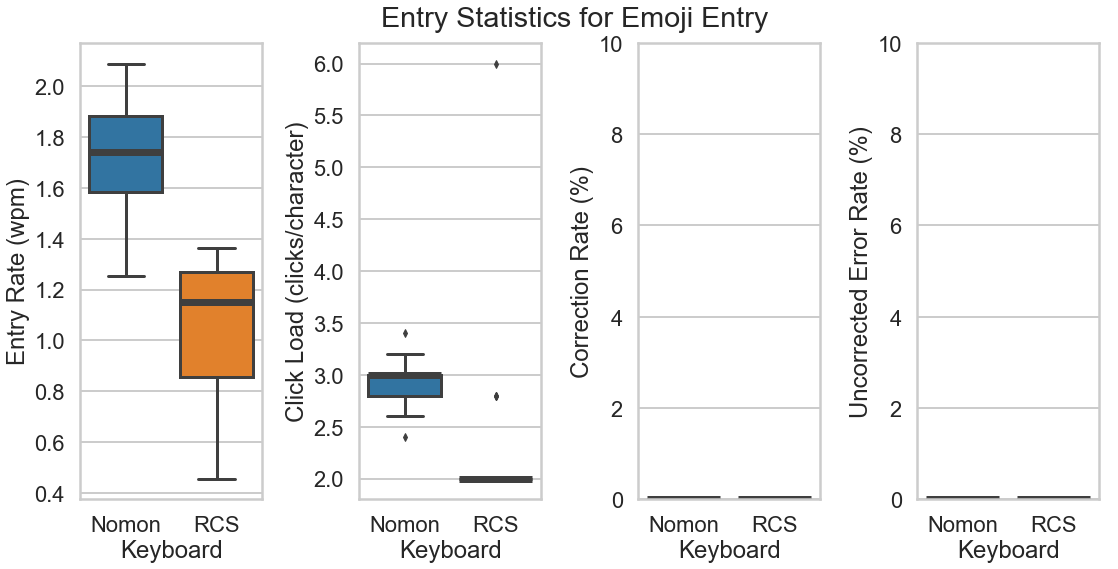

In [7]:
emoji_df = entry_df[entry_df["Session Number"] == 10]

entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/character)", "Correction Rate (%)", "Uncorrected Error Rate (%)"]
fig, axes = plt.subplots(1, 4,figsize=(16,8))
fig.tight_layout(pad=1.5)
axes = list(axes)
fig.suptitle('Entry Statistics for Emoji Entry')

for entry_stat in entry_stats:
    cur_ax = axes.pop(0)
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=emoji_df, ax=cur_ax)
    if cur_ax.get_ylim()[0] < 0:
        cur_ax.set_ylim(bottom=0.)
    if entry_stat in ["Correction Rate (%)", "Uncorrected Error Rate (%)"]:
        if cur_ax.get_ylim()[1] < 1:
            cur_ax.set_ylim(top=10)
    
    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
        
    plt.plot()
    
    nomon_responses = emoji_df[emoji_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_responses = emoji_df[emoji_df.Keyboard == "RCS"][entry_stat].values
    
    try:
        pvalue = stats.mannwhitneyu(nomon_responses, rowcol_responses).pvalue
    except ValueError:
        pvalue = "Nan"
    finally:
        print(entry_stat, pvalue)
        
    

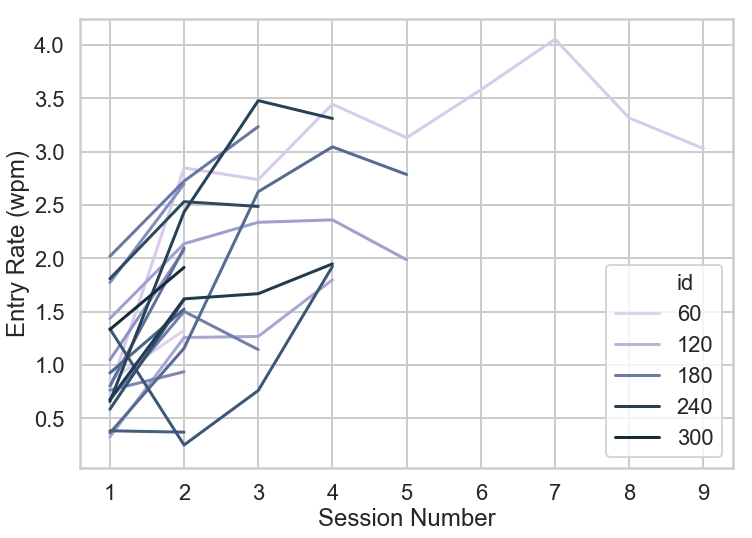

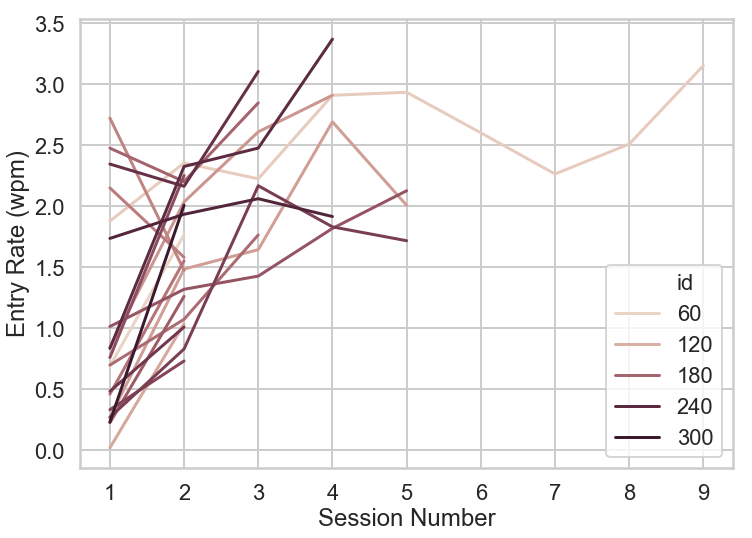

In [27]:
sns.set_context("poster")
sns.set_style("whitegrid")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Entry Rate (wpm)", hue="id",
              data=entry_df[(entry_df["Session Number"] > 0) & (entry_df["Session Number"] < 10) & 
                            (entry_df["Keyboard"] == "Nomon")], ax=ax, palette="ch:2.5,.25", ci=None)

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(x="Session Number", y="Entry Rate (wpm)", hue="id",
              data=entry_df[(entry_df["Session Number"] > 0) & (entry_df["Session Number"] < 10) & 
                            (entry_df["Keyboard"] == "RCS")], ax=ax, palette="ch:0.5,.25", ci=None)
